In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [ ]:
!pip install scikit-learn

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error

import tensorflow as tf
print(tf.__version__)

from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error


2.17.0


In [ ]:
train = pd.read_csv('/content/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/test.csv', parse_dates=['date'])

In [ ]:
train.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


In [ ]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


In [ ]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [ ]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [ ]:
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Store %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)


In [ ]:
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

In [ ]:
#training
train = train[(train['date'] >= '2017-01-01')]

In [ ]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,19.0
1,1,1,2017-01-02,15.0
2,1,1,2017-01-03,10.0
3,1,1,2017-01-04,16.0
4,1,1,2017-01-05,14.0


In [ ]:
#Transform the data into a time series problem
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
#We will use the current timestep and the last 29 to forecast 90 days ahead
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1,1,9.0,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1,1,17.0,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1,1,15.0,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1,1,17.0,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1,1,24.0,1.0,1.0,19.0


In [ ]:
#Drop rows with different item or store values than the shifted columns
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [ ]:
#Remove unwanted columns
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [ ]:
!pip install scikit-learn

In [ ]:
# Label
#train and validation split
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (100746, 30)
Validation set shape (67164, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
18801,97.0,111.0,90.0,115.0,123.0,70.0,99.0,74.0,107.0,108.0,...,85.0,95.0,123.0,109.0,127.0,132.0,87.0,101.0,102.0,114.0
160385,38.0,43.0,43.0,55.0,47.0,51.0,38.0,41.0,37.0,59.0,...,41.0,38.0,38.0,53.0,53.0,45.0,44.0,24.0,30.0,37.0
73123,55.0,45.0,41.0,46.0,47.0,36.0,30.0,46.0,41.0,42.0,...,38.0,36.0,40.0,50.0,44.0,44.0,40.0,38.0,50.0,49.0
90428,139.0,157.0,85.0,99.0,136.0,110.0,121.0,123.0,147.0,91.0,...,130.0,128.0,128.0,95.0,116.0,110.0,117.0,118.0,129.0,132.0
167151,86.0,58.0,88.0,87.0,114.0,113.0,64.0,76.0,87.0,81.0,...,55.0,66.0,59.0,53.0,63.0,59.0,77.0,39.0,56.0,62.0


In [ ]:
#CNN
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Normalize your data if you haven't already
# X_train_normalized = (X_train - X_train.mean()) / X_train.std()
# X_valid_normalized = (X_valid - X_train.mean()) / X_train.std()

model_gru = Sequential([
    GRU(32, activation='tanh', return_sequences=True,
        input_shape=(X_train_series.shape[1], X_train_series.shape[2]),
        kernel_regularizer=l2(1e-6)),
    BatchNormalization(),
    Dropout(0.2),
    GRU(16, activation='tanh', return_sequences=False, kernel_regularizer=l2(1e-6)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu', kernel_regularizer=l2(1e-6)),
    Dense(1)
])

# Compile the model with a lower initial learning rate
optimizer = Adam(learning_rate=0.001)
model_gru.compile(optimizer=optimizer, loss='mse')
model_gru.summary()

# Adjust callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

# Train the model
history = model_gru.fit(X_train_series, Y_train,
                        validation_data=(X_valid_series, Y_valid),
                        epochs=150,
                        batch_size=128,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 32)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 16)                  │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,241 (24.38 KB)

 Trainable params: 6,145 (24.00 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/150
788/788 - 26s - 32ms/step - loss: 1456.8732 - val_loss: 478.7119 - learning_rate: 0.0010
Epoch 2/150
788/788 - 7s - 9ms/step - loss: 521.8652 - val_loss: 423.3784 - learning_rate: 0.0010
Epoch 3/150
788/788 - 10s - 13ms/step - loss: 496.4165 - val_loss: 482.1129 - learning_rate: 0.0010
Epoch 4/150
788/788 - 10s - 13ms/step - loss: 483.2567 - val_loss: 499.2367 - learning_rate: 0.0010
Epoch 5/150
788/788 - 11s - 14ms/step - loss: 485.2635 - val_loss: 435.0315 - learning_rate: 0.0010
Epoch 6/150
788/788 - 11s - 13ms/step - loss: 465.3181 - val_loss: 530.5663 - learning_rate: 0.0010
Epoch 7/150

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
788/788 - 10s - 13ms/step - loss: 456.5576 - val_loss: 510.8833 - learning_rate: 0.0010
Epoch 8/150
788/788 - 7s - 9ms/step - loss: 445.6442 - val_loss: 392.4590 - learning_rate: 2.0000e-04
Epoch 9/150
788/788 - 11s - 14ms/step - loss: 445.7855 - val_loss: 386.1198 - learning_rate: 2.0000e-04
Epoch 10/150
788/

In [ ]:
import numpy as np

In [ ]:
#CNN on train and validation
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on training and validation sets using the LSTM model
lstm_train_pred = model_gru.predict(X_train_series)
lstm_valid_pred = model_gru.predict(X_valid_series)

# Calculate RMSE for training and validation sets
train_rmse = np.sqrt(mean_squared_error(Y_train, lstm_train_pred))
valid_rmse = np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred))

print('Train RMSE:', train_rmse)
print('Validation RMSE:', valid_rmse)


3149/3149 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
2099/2099 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Train RMSE: 19.444908925459192
Validation RMSE: 19.456085206768616


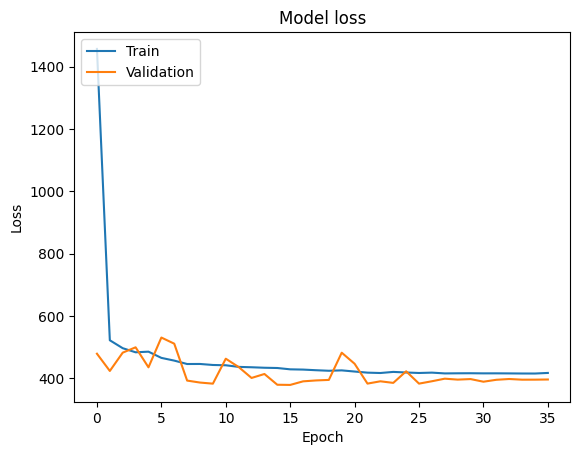

In [ ]:


import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


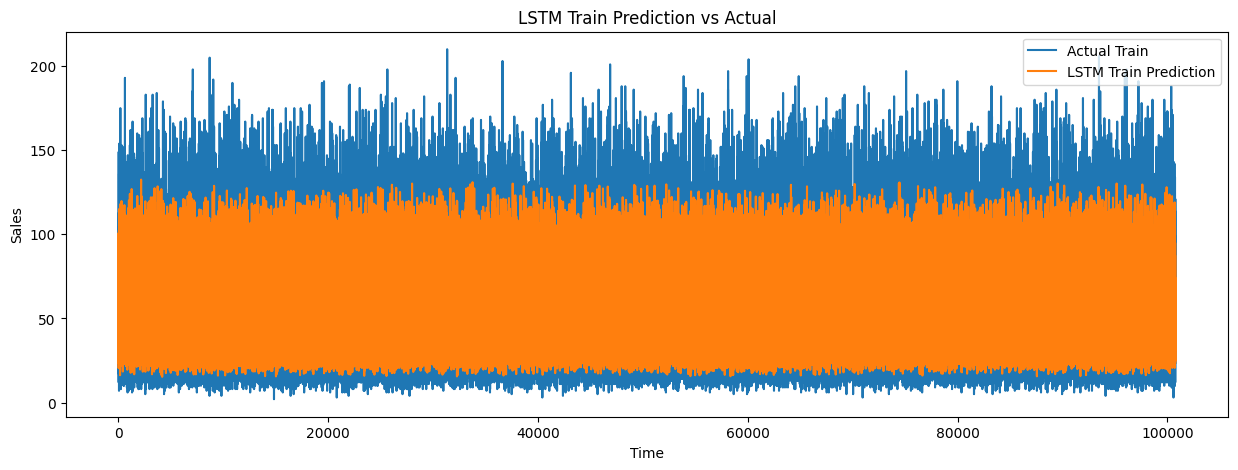

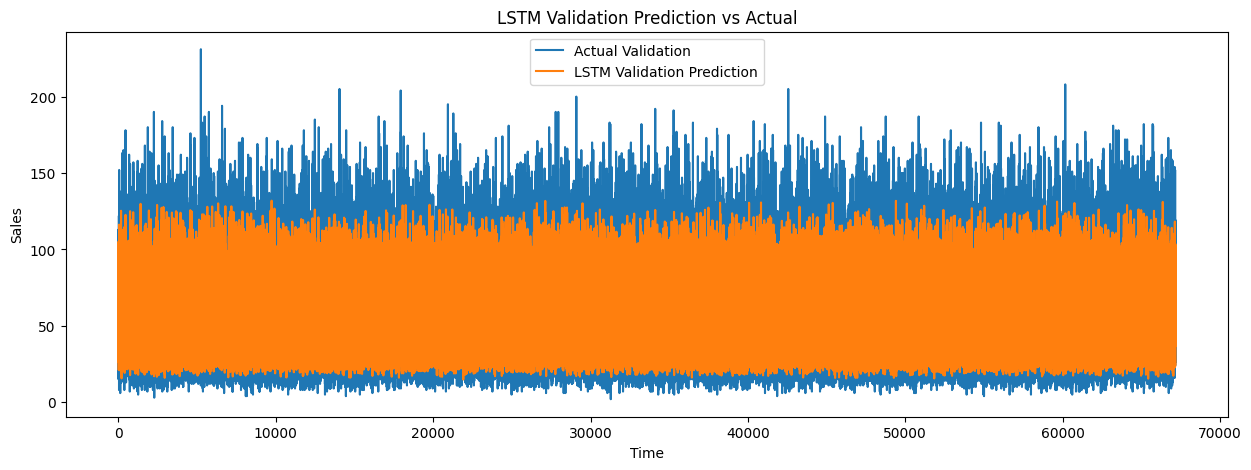

In [ ]:


plt.figure(figsize=(15, 5))
plt.plot(Y_train, label='Actual Train')
plt.plot(lstm_train_pred, label='LSTM Train Prediction')
plt.title('LSTM Train Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(Y_valid, label='Actual Validation')
plt.plot(lstm_valid_pred, label='LSTM Validation Prediction')
plt.title('LSTM Validation Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

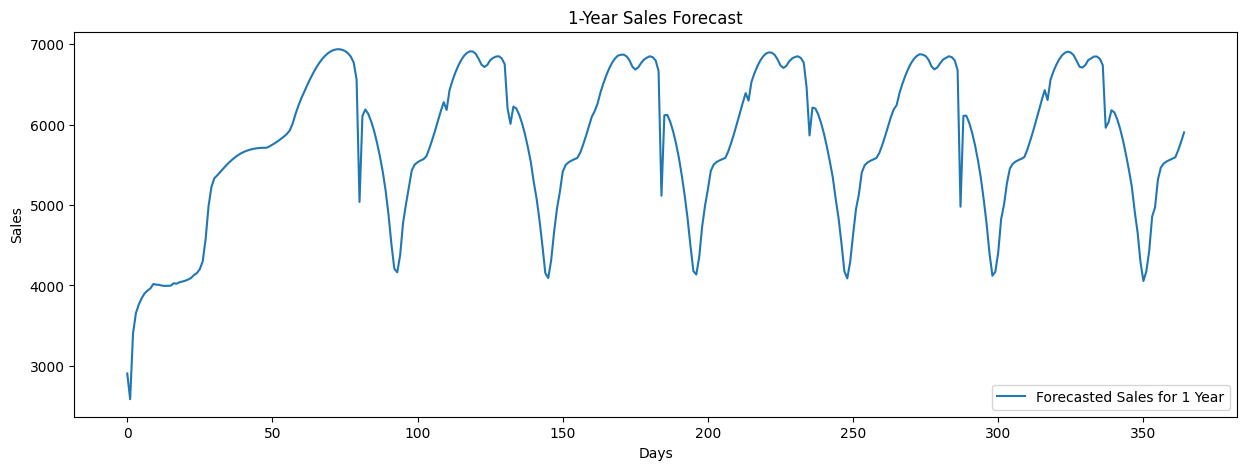

In [ ]:
# import numpy as np

# # We will use the last 30 days of the training data for forecasting
# input_sequence = X_train_series[-1].reshape(1, 30, 1)

# # Number of days to forecast (1 year)
# forecast_days = 365
# forecasted_sales = []

# for day in range(forecast_days):
#     # Predict the next day sales
#     next_day_sales = model_gru.predict(input_sequence)

#     # Append the prediction to the forecast list
#     forecasted_sales.append(next_day_sales[0][0])

#     # Reshape next_day_sales to (1, 1, 1) to match the input sequence shape
#     next_day_sales = next_day_sales.reshape(1, 1, 1)

#     # Update the input sequence by removing the first value and adding the new prediction
#     input_sequence = np.append(input_sequence[:, 1:, :], next_day_sales, axis=1)

# # Convert forecasted sales to a numpy array
# forecasted_sales = np.array(forecasted_sales)

# # Plot the forecasted sales
# plt.figure(figsize=(15, 5))
# plt.plot(forecasted_sales, label='Forecasted Sales for 1 Year')
# plt.title('1-Year Sales Forecast')
# plt.xlabel('Days')
# plt.ylabel('Sales')
# plt.legend()
# plt.show()
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data (e.g., on the sales column)
# Assuming Y_train contains the sales values
scaler.fit(Y_train.reshape(-1, 1))

# Normalize the input sequence using the fitted scaler
input_sequence = scaler.transform(X_train_series[-1].reshape(-1, 1)).reshape(1, 30, 1)

# Number of days to forecast (1 year)
forecast_days = 365
forecasted_sales = []

for day in range(forecast_days):
    # Predict the next day sales
    next_day_sales = model_gru.predict(input_sequence)

    # Denormalize the predicted value (scale it back to original range)
    next_day_sales = scaler.inverse_transform(next_day_sales)[0][0]

    # Append the prediction to the forecast list
    forecasted_sales.append(next_day_sales)

    # Prepare next input sequence (use actual data for the first 30 steps if possible)
    next_day_sales_normalized = scaler.transform(np.array([[next_day_sales]]))

    # Update the input sequence by removing the first value and adding the new prediction
    input_sequence = np.append(input_sequence[:, 1:, :], next_day_sales_normalized.reshape(1, 1, 1), axis=1)

# Convert forecasted sales to a numpy array
forecasted_sales = np.array(forecasted_sales)

# Plot the forecasted sales
plt.figure(figsize=(15, 5))
plt.plot(forecasted_sales, label='Forecasted Sales for 1 Year')
plt.title('1-Year Sales Forecast')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.show()


